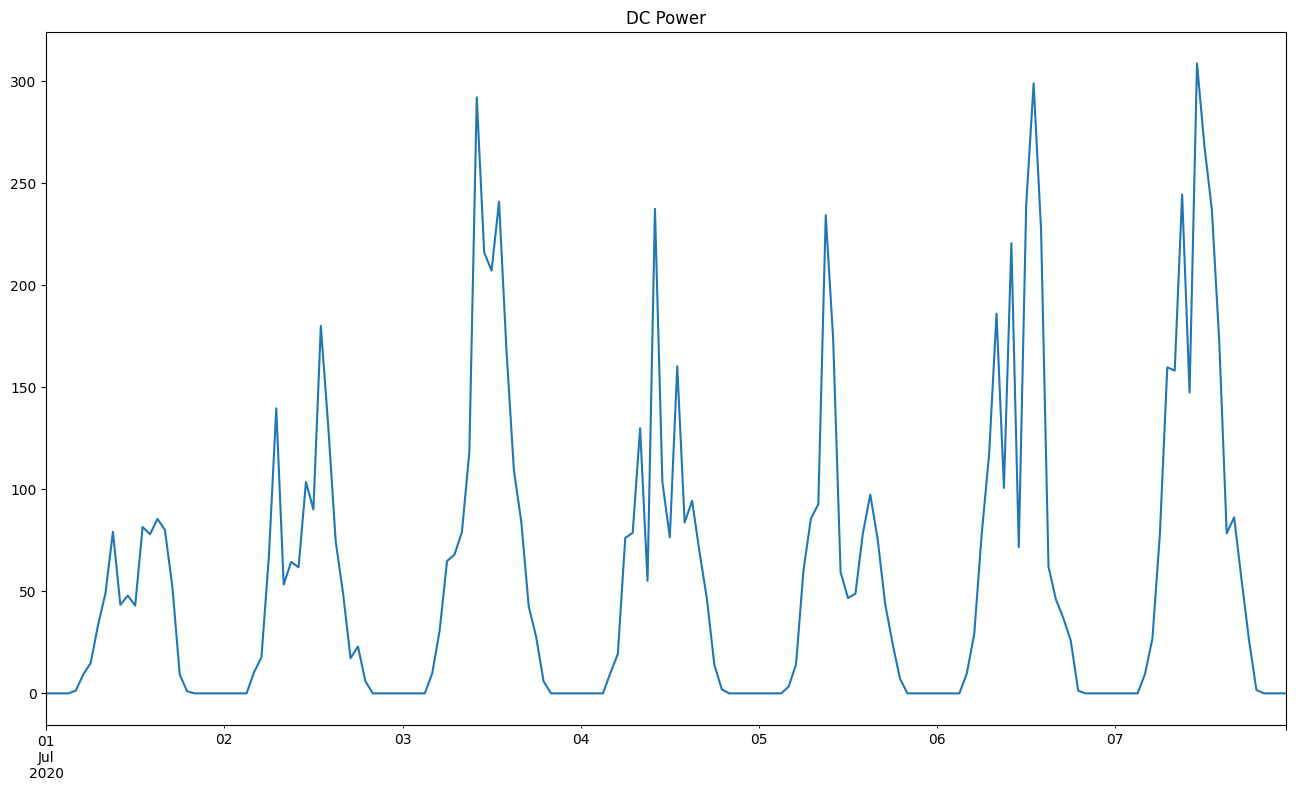

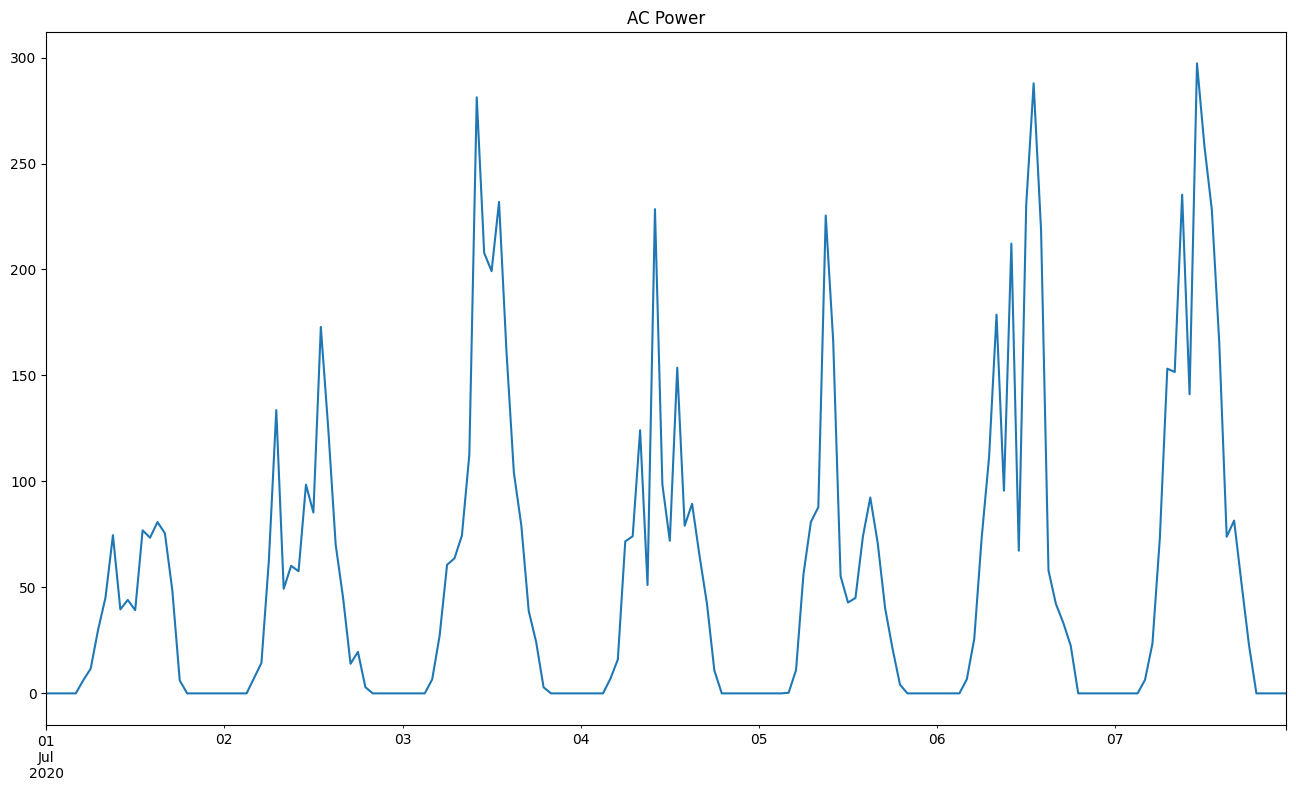

In [3]:
import pvlib
from pvlib.location import Location
import pandas as pd
import matplotlib.pyplot as plt

celltype ='monoSi'
pdc0 = 400,
v_mp = 44.1
i_mp = 9.08
v_oc = 53.4
i_sc = 9.60
alpha_sc = 0.0005 * i_sc
beta_voc = -0.0029 * v_oc
gamma_pdc = -0.0037
cells_in_series = 6*27
temp_ref = 25

latitude = 50.941389
longitude = 6.958711

location = Location(latitude=latitude, longitude=latitude,
                    tz='Europe/Berlin', altitude=80, name='Cologne Cathedral')

surface_tilt=45
surface_azimuth=180

start="2020-07-01 00:00"
end= "2020-07-07 23:00"

poa_data_2020 = pd.read_csv("poa_data_2020.csv", index_col=0)
poa_data_2020.index = pd.date_range(start="2020-01-01 00:000",
                                  periods=len(poa_data_2020.index),
                                  freq="h")
poa_data = poa_data_2020[start:end]

solarpos = location.get_solarposition(times=pd.date_range(start=start, end=end,
                                                          freq="h"))

# Calcula o ângulo de incidência do vetor solar em uma superfície.
#Este é o ângulo entre o vetor solar e a superfície normal.
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solarpos.apparent_zenith,
                           solarpos.azimuth)

# Determina o modificador do ângulo de incidência
iam = pvlib.iam.ashrae(aoi)

# A irradiância (W/m2) que é convertida em fotocorrente.
effective_irradiance = poa_data["poa_direct"] * iam + poa_data["poa_diffuse"]

# Temperatura da celula.
temp_cell = pvlib.temperature.faiman(poa_data["poa_global"], poa_data["temp_air"],
                                     poa_data["wind_speed"])

# Alimentação DC dos módulos
result_dc = pvlib.pvsystem.pvwatts_dc(effective_irradiance, temp_cell,
                                      pdc0, gamma_pdc=gamma_pdc, temp_ref=25)

result_dc.plot(figsize=(16,9))
plt.title("DC Power")
plt.show()

# Alimentação AC dos módulos
results_ac = pvlib.inverter.pvwatts(pdc=result_dc, pdc0=500, eta_inv_nom=0.961,
                                  eta_inv_ref=0.9637)
results_ac.plot(figsize=(16,9))
plt.title("AC Power")
plt.show()